In [131]:
import warnings

warnings.filterwarnings("ignore")
import sys  
sys.path.insert(0, 'C://Users//Adminn//Downloads')
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import signal
import numpy as np
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
import xgboost as XGB
from sklearn.ensemble import RandomForestClassifier
import time
from tqdm import tqdm
import scipy.stats as stats
import matplotlib.pyplot as plt
import math
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.calibration import CalibratedClassifierCV
from itertools import islice
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [82]:
pip install catboost

     ---------------------------------------- 74.0/74.0 MB 8.2 MB/s eta 0:00:00
     ---------------------------------------- 47.0/47.0 kB 2.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
data = pd.read_csv('C://Users//Adminn//Downloads//raw_df.csv')
df =pd.read_csv('C://Users//Adminn//Downloads//modified_df.csv')

In [3]:
info = pd.read_csv('C://Users//Adminn//Downloads//info.csv')

In [4]:
data.rank_team_1.fillna(40.0,inplace = True)
data.rank_team_2.fillna(40.0,inplace = True)
data["rank-points_team_1"].replace(0.0,40.0,inplace=True)
data['rank-points_team_2'].replace(0.0,40.0,inplace=True)


In [5]:
df.rank_team_1.fillna(40.0,inplace = True)
df.rank_team_2.fillna(40.0,inplace = True)
df["rank-points_team_1"].replace(0.0,40.0,inplace=True)
df['rank-points_team_2'].replace(0.0,40.0,inplace=True)
df['team_2_rating'] = df['team_1_rating'] - df['team_rating_diff'] 

In [6]:
data[data.rank_team_1.isnull()]['rank_team_1']

Series([], Name: rank_team_1, dtype: float64)

In [18]:
pair = data[['rank-points_team_2','rank-points_team_1','team_1_won']]

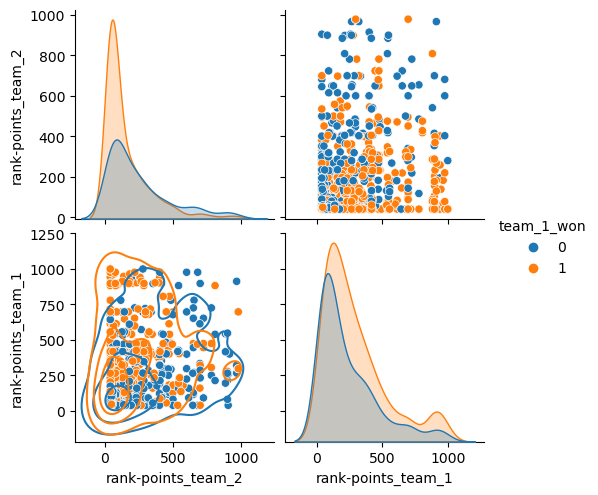

In [19]:
g = sns.pairplot(pair, hue = 'team_1_won',diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

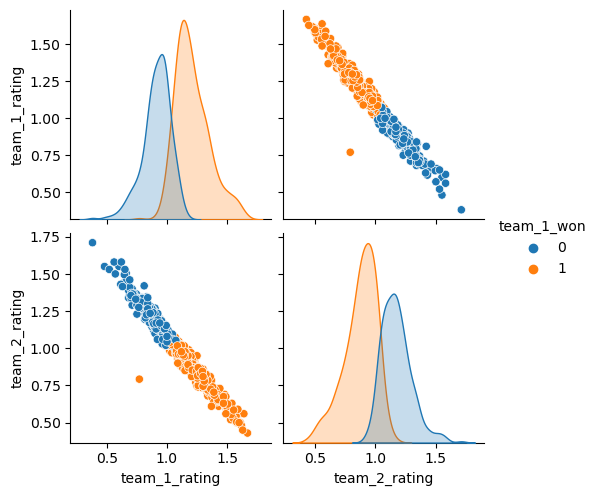

In [17]:
pair2 = df[['team_1_rating','team_2_rating','team_1_won']]
g = sns.pairplot(pair2, hue = 'team_1_won',diag_kind="kde")

In [7]:
X = df[['rank_team_2','rank_team_1','rank-points_team_1','rank-points_team_2']]
y = df.team_1_won

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [9]:
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

mean_absolute_error(y_test, log_reg.predict_proba(X_test)[:,0])

0.5620872670984925

In [10]:
rnd_for = RandomForestClassifier()
rnd_for.fit(X_train,y_train)

mean_absolute_error(y_test, rnd_for.predict_proba(X_test)[:,0])

0.5595953632809976

In [20]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [1]:

params = {
    # Параметры, которые мы будем тюнить
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Другие необходимые параметры
    'objective':'binary:logistic',
    'eval_metric':'mae'
}

In [22]:
%%time
num_boost_round = 2000
model = XGB.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)


[0]	Test-mae:0.48973
[1]	Test-mae:0.47868
[2]	Test-mae:0.46901
[3]	Test-mae:0.46463
[4]	Test-mae:0.45995
[5]	Test-mae:0.45548
[6]	Test-mae:0.45263
[7]	Test-mae:0.45184
[8]	Test-mae:0.44797
[9]	Test-mae:0.44557
[10]	Test-mae:0.44575
[11]	Test-mae:0.44639
[12]	Test-mae:0.44628
[13]	Test-mae:0.44715
[14]	Test-mae:0.44698
[15]	Test-mae:0.44586
[16]	Test-mae:0.44546
[17]	Test-mae:0.44619
[18]	Test-mae:0.44768
[19]	Test-mae:0.44799
[20]	Test-mae:0.44787
[21]	Test-mae:0.44835
[22]	Test-mae:0.44817
[23]	Test-mae:0.44655
[24]	Test-mae:0.44760
[25]	Test-mae:0.44764
Wall time: 56.9 ms


In [15]:
model.best_score_

{'learn': {'Logloss': 0.6259883958816528}}

In [23]:
model = CatBoostClassifier(iterations=2,
                           depth=2,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=True)
model.fit(X_train, y_train)

0:	learn: 0.6430794	total: 155ms	remaining: 155ms
1:	learn: 0.6259884	total: 157ms	remaining: 0us


In [95]:
mean_absolute_error(y_test,model.predict_proba(X_test)[:,0])

0.5560308153407928

In [12]:
astr = df[(df["team2"] == 'Astralis') | (df["team1"] == 'Astralis')][['rank_team_2','rank_team_1','rank-points_team_1','rank-points_team_2','team_1_rating','team_2_rating','team_1_won']]
mouz = df[(df["team2"] == 'MOUZ') | (df["team1"] == 'MOUZ')][['rank_team_2','rank_team_1','rank-points_team_1','rank-points_team_2','team_1_rating','team_2_rating','team_1_won']]
big  = df[(df["team2"] == 'BIG') | (df["team1"] == 'BIG')][['rank_team_2','rank_team_1','rank-points_team_1','rank-points_team_2','team_1_rating','team_2_rating','team_1_won']]
ence = df[(df["team2"] == 'ENCE') | (df["team1"] == 'ENCE')][['rank_team_2','rank_team_1','rank-points_team_1','rank-points_team_2','team_1_rating','team_2_rating','team_1_won']]
faze = df[(df["team2"] == 'FaZe') | (df["team1"] == 'FaZe')][['rank_team_2','rank_team_1','rank-points_team_1','rank-points_team_2','team_1_rating','team_2_rating','team_1_won']]
heroic= df[(df["team2"] == 'Heroic') | (df["team1"] == 'Heroic')][['rank_team_2','rank_team_1','rank-points_team_1','rank-points_team_2','team_1_rating','team_2_rating','team_1_won']]
vital= df[(df["team2"] == 'Vitality') | (df["team1"] == 'Vitality')][['rank_team_2','rank_team_1','rank-points_team_1','rank-points_team_2','team_1_rating','team_2_rating','team_1_won']]
nip= df[(df["team2"] == 'Ninjas in Pyjamas') | (df["team1"] == 'Ninjas in Pyjamas')][['rank_team_2','rank_team_1','rank-points_team_1','rank-points_team_2','team_1_rating','team_2_rating','team_1_won']]
navi= df[(df["team2"] == 'Natus Vincere') | (df["team1"] == 'Natus Vincere')][['rank_team_2','rank_team_1','rank-points_team_1','rank-points_team_2','team_1_rating','team_2_rating','team_1_won']]
outsiders= df[(df["team2"] == 'Outsiders') | (df["team1"] == 'Outsiders')][['rank_team_2','rank_team_1','rank-points_team_1','rank-points_team_2','team_1_rating','team_2_rating','team_1_won']]
g2= df[(df["team2"] == 'G2') | (df["team1"] == 'G2')][['rank_team_2','rank_team_1','rank-points_team_1','rank-points_team_2','team_1_rating','team_2_rating','team_1_won']]
og= df[(df["team2"] == 'OG') | (df["team1"] == 'OG')][['rank_team_2','rank_team_1','rank-points_team_1','rank-points_team_2','team_1_rating','team_2_rating','team_1_won']]
cw= df[(df["team2"] == 'Copenhagen Flames') | (df["team1"] == 'Copenhagen Flames')][['rank_team_2','rank_team_1','rank-points_team_1','rank-points_team_2','team_1_rating','team_2_rating','team_1_won']]
furia= df[(df["team2"] == 'FURIA') | (df["team1"] == 'FURIA')][['rank_team_2','rank_team_1','rank-points_team_1','rank-points_team_2','team_1_rating','team_2_rating','team_1_won']]
liquid= df[(df["team2"] == 'Liquid') | (df["team1"] == 'Liquid')][['rank_team_2','rank_team_1','rank-points_team_1','rank-points_team_2','team_1_rating','team_2_rating','team_1_won']]


teams=[astr,mouz,big,ence,faze,heroic,vital,nip,navi,outsiders,g2,og,cw,furia,liquid]

In [99]:
df.team1.value_counts().head(45).reset_index()['index'][2]

'Heroic'

In [25]:
teamas={}
for new_team in (df.team1.value_counts()+df.team2.value_counts()).sort_values(ascending=False).head(30).reset_index()['index']:
    team = df[(df["team1"] == new_team) | (df["team2"] == new_team)][['rank_team_2','rank_team_1','rank-points_team_1','rank-points_team_2','team_1_rating','team_1_won']]
    team['team_2_rating'] = df[(df["team2"] == new_team)]['team_2_rating']
    
    teamas[new_team]=team
    team =[] 
for name,value in teamas.items():
    
    value.loc[value['team_2_rating'].notna(),'team_1_rating'] = 0
    value.fillna(0,inplace=True)
    value['team_true_rating'] = value.team_1_rating + value.team_2_rating  
for team in teamas.values():
    team['mean_10_rating']=1
    team.mean_10_rating.iloc[1]=team.iloc[0].team_true_rating
    n=0
    j=0
    for x in range(2,len(team.mean_10_rating)):
        
        if n<=9:
            team.mean_10_rating.iloc[x] = team.iloc[0:x].team_true_rating.mean()
        n+=1
        if n>9:
            j+=1
            team.mean_10_rating.iloc[x] = team.iloc[j:x].team_true_rating.mean()
            
for team in teamas.values():
    team['mean_5_rating']=1
    team.mean_5_rating.iloc[1]=team.iloc[0].team_true_rating
    n=0
    j=0
    for x in range(2,len(team.mean_5_rating)):
        
        if n<=4:
            team.mean_5_rating.iloc[x] = team.iloc[0:x].team_true_rating.mean()
        n+=1
        if n>4:
            j+=1
            team.mean_5_rating.iloc[x] = team.iloc[j:x].team_true_rating.mean() 
for team in teamas.values():
    team['mean_3_rating']=1
    team.mean_3_rating.iloc[1]=team.iloc[0].team_true_rating
    
    n=0
    j=0
    for x in range(2,len(team.mean_3_rating)):
        
        if n<1:
            team.mean_3_rating.iloc[x] = team.iloc[n:x].team_true_rating.mean()
        n+=1
        if n>=2:
            
            team.mean_3_rating.iloc[x] = team.iloc[j:x].team_true_rating.mean() 
            j+=1

In [26]:
for team in teamas.values():
    team['team_1_wins_in_3']=0.5
    team.team_1_wins_in_3.iloc[1]=team.iloc[0].team_1_won/2
    
    n=0
    j=0
    for x in range(2,len(team.team_1_wins_in_3)):
        
        if n<1:
            team.team_1_wins_in_3.iloc[x] = team.iloc[n:x].team_1_won.mean()
        n+=1
        if n>=2:
            
            team.team_1_wins_in_3.iloc[x] = team.iloc[j:x].team_1_won.mean() 
            j+=1
for team in teamas.values():
    team['team_1_wins_in_5']=0.5
    team.team_1_wins_in_5.iloc[1]=team.iloc[0].team_1_won/2
    
    n=0
    j=0
    for x in range(2,len(team.team_1_wins_in_5)):
        
        if n<=4:
            team.team_1_wins_in_5.iloc[x] = team.iloc[0:x].team_1_won.mean()
        n+=1
        if n>4:
            j+=1
            team.team_1_wins_in_5.iloc[x] = team.iloc[j:x].team_1_won.mean() 
            
for team in teamas.values():
    team['team_1_wins_in_10']=0.5
    team.team_1_wins_in_10.iloc[1]=team.iloc[0].team_1_won/2
    
    n=0
    j=0
    for x in range(1,len(team.team_1_wins_in_10)):
        
        if n<=10:
            team.team_1_wins_in_10.iloc[x] = team.iloc[0:x].team_1_won.mean()
        n+=1
        if n>10:
            j+=1
            team.team_1_wins_in_10.iloc[x] = team.iloc[j:x].team_1_won.mean() 
            


In [27]:
df.team1.value_counts().head(15).reset_index()['index']

0                  ENCE
1                  MOUZ
2                Heroic
3                   BIG
4                  FaZe
5              Astralis
6              Vitality
7     Ninjas in Pyjamas
8         Natus Vincere
9             Outsiders
10                   G2
11    Copenhagen Flames
12                   OG
13                FURIA
14               Liquid
Name: index, dtype: object

In [28]:
teamas['Liquid'].head(5)

,rank_team_2,rank_team_1,rank-points_team_1,rank-points_team_2,team_1_rating,team_1_won,team_2_rating,team_true_rating,mean_10_rating,mean_5_rating,mean_3_rating,team_1_wins_in_3,team_1_wins_in_5,team_1_wins_in_10
6,12.0,3.0,722.0,296.0,1.02,0,0.000000,1.020000,1.000000,1.000000,1.000000,0.500000,0.500000,0.500000
9,3.0,10.0,446.0,722.0,0.00,1,0.986667,0.986667,1.020000,1.020000,1.020000,0.000000,0.000000,0.000000
22,3.0,4.0,653.0,722.0,0.00,0,1.040000,1.040000,1.003333,1.003333,1.003333,0.500000,0.500000,0.500000
29,3.0,26.0,92.0,722.0,0.00,0,1.300000,1.300000,1.015556,1.015556,1.015556,0.333333,0.333333,0.333333
38,3.0,7.0,475.0,722.0,0.00,1,0.560000,0.560000,1.086667,1.086667,1.108889,0.333333,0.250000,0.250000


In [336]:
teamas['Vitality'].iloc[6:11].team_true_rating.mean()

1.0333333333333334

(<AxesSubplot:>, <AxesSubplot:>)

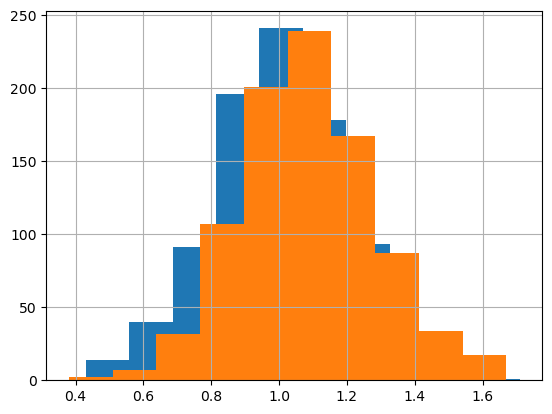

In [129]:
df.team_2_rating.hist(),df.team_1_rating.hist()

In [150]:
n=0
mean=0
seed=0
testers = []
final_label = []
for te in teamas.values():
    rnd_for = RandomForestClassifier(random_state=seed)
    y_team=te.team_1_won
    X_team=te[['rank-points_team_1','rank-points_team_2','rank_team_1','rank_team_2']]
    
    
    df_train, df_test, y_train, y_test = train_test_split(X_team, y_team, test_size = 0.3, random_state = 0)
    rnd_for.fit(df_train,y_train)
    
    mean+=(mean_absolute_error(y_test, rnd_for.predict(df_test)))*(len(te))
    testers.append(y_test)
    final_label.append(rnd_for.predict(df_test))
    
print(mean/1376)    

0.35982409247939456


In [106]:
testers[2]

514    0
348    0
356    0
642    0
738    1
374    0
618    1
577    0
407    1
138    1
410    0
467    0
387    1
587    1
743    1
81     1
222    1
364    0
220    1
309    0
Name: team_1_won, dtype: int64

In [121]:
final_label[2]

array([0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0],
      dtype=int64)

In [2]:
teamas['Astralis'].head(30)

NameError: name 'teamas' is not defined

In [117]:
teamas.keys()

dict_keys(['ENCE', 'MOUZ', 'Astralis', 'BIG', 'Vitality', 'FaZe', 'Heroic', 'Outsiders', 'FURIA', 'Liquid', 'fnatic', 'Natus Vincere', 'Ninjas in Pyjamas', 'forZe', 'G2', 'OG', 'Movistar Riders', 'Copenhagen Flames', 'Cloud9', 'Eternal Fire', 'Spirit', 'Sprout', 'Complexity', 'Bad News Eagles', 'SKADE', 'Entropiq', 'Imperial', '9z', 'MIBR', 'HEET'])

In [56]:
rnd_for.predict_proba(df_test)[:,0]

array([0.68, 0.19, 0.75, 0.76, 0.15, 0.52, 0.75, 0.64])

In [229]:

rnd_for = RandomForestClassifier(random_state=seed)
y_team=df.team_1_won
X_team=df[['rank-points_team_1','rank-points_team_2','rank_team_1','rank_team_2']]
    
df_train, df_test, y_train, y_test = train_test_split(X_team, y_team, test_size = 0.3, random_state = 0)
rnd_for.fit(df_train,y_train)
    


    
print(mean_absolute_error(y_test, rnd_for.predict(df_test)))    

0.417910447761194


In [230]:
Accuracy = metrics.accuracy_score(y_test.to_list(), rnd_for.predict(df_test))
Precision = metrics.precision_score(y_test.to_list(), rnd_for.predict(df_test))
Sensitivity_recall = metrics.recall_score(y_test.to_list(), rnd_for.predict(df_test))
Specificity  = metrics.recall_score(y_test.to_list(), rnd_for.predict(df_test), pos_label=0)

In [233]:
y_test

497    0
649    1
278    0
31     1
255    0
      ..
263    1
720    0
716    1
855    1
64     1
Name: team_1_won, Length: 268, dtype: int64

In [143]:
Precision

0.65625

In [144]:
Sensitivity_recall

0.6481481481481481

In [135]:
confusion_matrix= confusion_matrix(y_test.to_list(), rnd_for.predict(df_test))

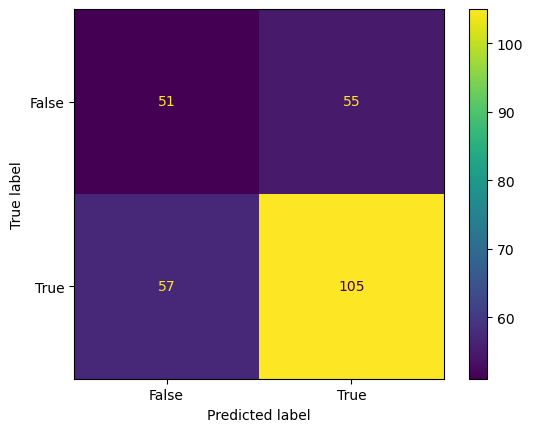

In [136]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [148]:
df.team_1_won.value_counts()

1    523
0    370
Name: team_1_won, dtype: int64

In [49]:
df.columns

Index(['index', 'team1score', 'team2score', 'team1score_t_on_map_1',
       'team1score_ct_on_map_1', 'team2score_t_on_map_1',
       'team2score_ct_on_map_1', 'team1score_t_on_map_2',
       'team1score_ct_on_map_2', 'team2score_t_on_map_2',
       'team2score_ct_on_map_2', 'team1score_t_on_map_3',
       'team1score_ct_on_map_3', 'team2score_t_on_map_3',
       'team2score_ct_on_map_3', 'team1score_t_on_map_4',
       'team1score_ct_on_map_4', 'team2score_t_on_map_4',
       'team2score_ct_on_map_4', 'team1score_t_on_map_5',
       'team1score_ct_on_map_5', 'team2score_t_on_map_5',
       'team2score_ct_on_map_5', 'team_1_won', 'rank_team_2',
       'rank-points_team_2', 'rank_team_1', 'rank-points_team_1',
       'team_1_rating', 'team_rating_diff', 'team_1_clutches',
       'team_clutches_diff', 'team_1_fb', 'team_fb_diff', 'team1', 'team2',
       'team_2_rating'],
      dtype='object')

In [33]:
teamas['Astralis'].drop(['team_1_won','team_1_rating','team_2_rating','team_true_rating','mean_5_rating','mean_10_rating'],axis=1)

,rank_team_2,rank_team_1,rank-points_team_1,rank-points_team_2,mean_3_rating,team_1_wins_in_3,team_1_wins_in_5,team_1_wins_in_10
71,10.0,8.0,339.0,279.0,1.000000,0.500000,0.500000,0.500000
76,8.0,3.0,696.0,339.0,0.925000,0.000000,0.000000,0.000000
81,20.0,8.0,339.0,120.0,1.015833,0.000000,0.000000,0.000000
116,26.0,8.0,339.0,58.0,1.030556,0.333333,0.333333,0.333333
138,8.0,40.0,40.0,339.0,1.030556,0.333333,0.250000,0.250000
...,...,...,...,...,...,...,...,...
732,25.0,9.0,266.0,77.0,1.106667,0.666667,0.800000,0.800000
734,1.0,9.0,266.0,898.0,1.048889,0.666667,0.800000,0.800000
738,40.0,9.0,266.0,40.0,1.030000,0.333333,0.600000,0.700000
741,9.0,7.0,351.0,204.0,1.085000,0.666667,0.600000,0.700000


In [ ]:
0.5873772371526085

In [35]:
n=0
mean=0
random_state = 0
num_boost_round =1000
dad = pd.DataFrame()
for te in teamas.values():
    y_team=te.team_1_won
    X_team=te.drop(['team_1_won','team_1_rating','team_2_rating','team_true_rating','team_1_wins_in_10','team_1_wins_in_5','mean_3_rating','mean_5_rating','mean_10_rating'],axis=1)
    
    df_train, df_test, y_train, y_test = train_test_split(X_team, y_team, test_size = 0.3, random_state = 0)
    dtrain = xgb.DMatrix(df_train, label=y_train)
    dtest = xgb.DMatrix(df_test, label=y_test)
    min_mae = float("Inf")
    best_params = None
    for max_depth, min_child_weight in gridsearch_params:
        print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
        # Update our parameters
        params['max_depth'] = max_depth
        params['min_child_weight'] = min_child_weight
        # Run CV
        cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
        mean_mae = cv_results['test-mae-mean'].min()
        boost_rounds = cv_results['test-mae-mean'].argmin()
        print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
        if mean_mae < min_mae:
            min_mae = mean_mae
            best_params = (max_depth,min_child_weight)
    print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))
    max_depth = 


IndentationError: unexpected indent (4023985420.py, line 17)

In [ ]:
0.6047420531643852, 0.6084028482085719, test = 0.6178221873544649,cv = 0.5744557284013249

In [49]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

In [45]:
parameters = {'num_feature' : [3,5,7,9],
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Другие необходимые параметры
    'objective':'binary:logistic',
    'eval_metric':'mae'
}

In [203]:

params = {
    # Параметры, которые мы будем тюнить
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Другие необходимые параметры
    'objective':'binary:logistic',
    'eval_metric':'error'
}

In [205]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [251]:
n=0
mean=0
random_state = 0
testers = []
final_label = []
for te in teamas.values():
    
    y_team=te.team_1_won
    X_team=te.drop(['team_1_won','team_1_rating','team_2_rating','team_true_rating','team_1_wins_in_10','team_1_wins_in_5','mean_3_rating','mean_5_rating','mean_10_rating','team_1_wins_in_3'],axis=1)
    
    df_train, df_test, y_train, y_test = train_test_split(X_team, y_team, test_size = 0.3, random_state = 0)
    
    clf=xgb.XGBClassifier(n_estimators =180, max_depth = 6, gamma = 1,
                    min_child_weight=1,
                    colsample_bytree=1,objective='binary:logistic')
    evaluation = [( df_train, y_train), ( df_test, y_test)]
    clf.fit(df_train,y_train,eval_set=evaluation, eval_metric="error",early_stopping_rounds=30)
    final_label.append(clf.predict(df_test))
    testers.append(y_test)
    
accuracy = accuracy_score(testers.to_list(), final_label>0.5)    

[0]	validation_0-error:0.19608	validation_1-error:0.21739
[1]	validation_0-error:0.23529	validation_1-error:0.21739
[2]	validation_0-error:0.23529	validation_1-error:0.21739
[3]	validation_0-error:0.23529	validation_1-error:0.21739
[4]	validation_0-error:0.23529	validation_1-error:0.21739
[5]	validation_0-error:0.23529	validation_1-error:0.21739
[6]	validation_0-error:0.23529	validation_1-error:0.21739
[7]	validation_0-error:0.23529	validation_1-error:0.21739
[8]	validation_0-error:0.27451	validation_1-error:0.26087
[9]	validation_0-error:0.27451	validation_1-error:0.26087
[10]	validation_0-error:0.27451	validation_1-error:0.26087
[11]	validation_0-error:0.27451	validation_1-error:0.26087
[12]	validation_0-error:0.27451	validation_1-error:0.26087
[13]	validation_0-error:0.27451	validation_1-error:0.26087
[14]	validation_0-error:0.27451	validation_1-error:0.26087
[15]	validation_0-error:0.27451	validation_1-error:0.26087
[16]	validation_0-error:0.27451	validation_1-error:0.26087
[17]	va

[17]	validation_0-error:0.15909	validation_1-error:0.55000
[18]	validation_0-error:0.15909	validation_1-error:0.55000
[19]	validation_0-error:0.15909	validation_1-error:0.55000
[20]	validation_0-error:0.15909	validation_1-error:0.55000
[21]	validation_0-error:0.15909	validation_1-error:0.55000
[22]	validation_0-error:0.15909	validation_1-error:0.55000
[23]	validation_0-error:0.15909	validation_1-error:0.55000
[24]	validation_0-error:0.15909	validation_1-error:0.55000
[25]	validation_0-error:0.15909	validation_1-error:0.55000
[26]	validation_0-error:0.15909	validation_1-error:0.55000
[27]	validation_0-error:0.15909	validation_1-error:0.55000
[28]	validation_0-error:0.15909	validation_1-error:0.55000
[29]	validation_0-error:0.15909	validation_1-error:0.55000
[30]	validation_0-error:0.15909	validation_1-error:0.55000
[0]	validation_0-error:0.24390	validation_1-error:0.33333
[1]	validation_0-error:0.24390	validation_1-error:0.33333
[2]	validation_0-error:0.19512	validation_1-error:0.16667


[14]	validation_0-error:0.18182	validation_1-error:0.40000
[15]	validation_0-error:0.18182	validation_1-error:0.40000
[16]	validation_0-error:0.18182	validation_1-error:0.40000
[17]	validation_0-error:0.18182	validation_1-error:0.40000
[18]	validation_0-error:0.18182	validation_1-error:0.40000
[19]	validation_0-error:0.18182	validation_1-error:0.40000
[20]	validation_0-error:0.18182	validation_1-error:0.40000
[21]	validation_0-error:0.18182	validation_1-error:0.40000
[22]	validation_0-error:0.18182	validation_1-error:0.40000
[23]	validation_0-error:0.18182	validation_1-error:0.40000
[24]	validation_0-error:0.18182	validation_1-error:0.40000
[25]	validation_0-error:0.18182	validation_1-error:0.40000
[26]	validation_0-error:0.18182	validation_1-error:0.40000
[27]	validation_0-error:0.18182	validation_1-error:0.40000
[28]	validation_0-error:0.18182	validation_1-error:0.40000
[29]	validation_0-error:0.18182	validation_1-error:0.40000
[30]	validation_0-error:0.18182	validation_1-error:0.400

[1]	validation_0-error:0.25926	validation_1-error:0.33333
[2]	validation_0-error:0.22222	validation_1-error:0.33333
[3]	validation_0-error:0.22222	validation_1-error:0.33333
[4]	validation_0-error:0.22222	validation_1-error:0.33333
[5]	validation_0-error:0.22222	validation_1-error:0.33333
[6]	validation_0-error:0.22222	validation_1-error:0.33333
[7]	validation_0-error:0.22222	validation_1-error:0.33333
[8]	validation_0-error:0.22222	validation_1-error:0.33333
[9]	validation_0-error:0.22222	validation_1-error:0.33333
[10]	validation_0-error:0.22222	validation_1-error:0.33333
[11]	validation_0-error:0.22222	validation_1-error:0.33333
[12]	validation_0-error:0.22222	validation_1-error:0.33333
[13]	validation_0-error:0.22222	validation_1-error:0.33333
[14]	validation_0-error:0.22222	validation_1-error:0.33333
[15]	validation_0-error:0.22222	validation_1-error:0.33333
[16]	validation_0-error:0.22222	validation_1-error:0.33333
[17]	validation_0-error:0.22222	validation_1-error:0.33333
[18]	v

[6]	validation_0-error:0.13043	validation_1-error:0.20000
[7]	validation_0-error:0.13043	validation_1-error:0.20000
[8]	validation_0-error:0.13043	validation_1-error:0.20000
[9]	validation_0-error:0.13043	validation_1-error:0.20000
[10]	validation_0-error:0.13043	validation_1-error:0.20000
[11]	validation_0-error:0.13043	validation_1-error:0.20000
[12]	validation_0-error:0.13043	validation_1-error:0.20000
[13]	validation_0-error:0.13043	validation_1-error:0.20000
[14]	validation_0-error:0.13043	validation_1-error:0.20000
[15]	validation_0-error:0.13043	validation_1-error:0.20000
[16]	validation_0-error:0.13043	validation_1-error:0.20000
[17]	validation_0-error:0.13043	validation_1-error:0.20000
[18]	validation_0-error:0.13043	validation_1-error:0.20000
[19]	validation_0-error:0.13043	validation_1-error:0.20000
[20]	validation_0-error:0.13043	validation_1-error:0.20000
[21]	validation_0-error:0.13043	validation_1-error:0.20000
[22]	validation_0-error:0.13043	validation_1-error:0.20000
[

[11]	validation_0-error:0.28571	validation_1-error:0.22222
[12]	validation_0-error:0.28571	validation_1-error:0.22222
[13]	validation_0-error:0.28571	validation_1-error:0.22222
[14]	validation_0-error:0.28571	validation_1-error:0.22222
[15]	validation_0-error:0.28571	validation_1-error:0.22222
[16]	validation_0-error:0.28571	validation_1-error:0.22222
[17]	validation_0-error:0.28571	validation_1-error:0.22222
[18]	validation_0-error:0.28571	validation_1-error:0.22222
[19]	validation_0-error:0.28571	validation_1-error:0.22222
[20]	validation_0-error:0.28571	validation_1-error:0.22222
[21]	validation_0-error:0.28571	validation_1-error:0.22222
[22]	validation_0-error:0.28571	validation_1-error:0.22222
[23]	validation_0-error:0.28571	validation_1-error:0.22222
[24]	validation_0-error:0.28571	validation_1-error:0.22222
[25]	validation_0-error:0.28571	validation_1-error:0.22222
[26]	validation_0-error:0.28571	validation_1-error:0.22222
[27]	validation_0-error:0.28571	validation_1-error:0.222

AttributeError: 'list' object has no attribute 'to_list'

In [252]:

accuracy = accuracy_score(testers[1], final_label[1])    

In [246]:
accuracy

0.6363636363636364

In [248]:
n=0
mean=0
random_state = 0
testers = []
final_label = []
for te in teamas.values():
    
    y_team=te.team_1_won
    X_team=te.drop(['team_1_won','team_1_rating','team_2_rating','team_true_rating','team_1_wins_in_10','team_1_wins_in_5','mean_3_rating','mean_5_rating','mean_10_rating'],axis=1)
    
    df_train, df_test, y_train, y_test = train_test_split(X_team, y_team, test_size = 0.3, random_state = 0)
    dtrain = xgb.DMatrix(df_train, label=y_train)
    dtest = xgb.DMatrix(df_test, label=y_test)

    model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=[(dtest, "Test")],
    early_stopping_rounds=30,
    )
    final_label.append(model.predict(dtest))
    testers.append(y_test)
    mean+=(model.best_score)*(len(te))
    n+=1
    print(n)
    
print(1 -mean/1376)

[0]	Test-error:0.47826
[1]	Test-error:0.43478
[2]	Test-error:0.47826
[3]	Test-error:0.47826
[4]	Test-error:0.47826
[5]	Test-error:0.43478
[6]	Test-error:0.47826
[7]	Test-error:0.47826
[8]	Test-error:0.47826
[9]	Test-error:0.47826
[10]	Test-error:0.47826
[11]	Test-error:0.43478
[12]	Test-error:0.43478
[13]	Test-error:0.43478
[14]	Test-error:0.43478
[15]	Test-error:0.43478
[16]	Test-error:0.43478
[17]	Test-error:0.43478
[18]	Test-error:0.43478
[19]	Test-error:0.43478
[20]	Test-error:0.43478
[21]	Test-error:0.43478
[22]	Test-error:0.43478
[23]	Test-error:0.43478
[24]	Test-error:0.43478
[25]	Test-error:0.43478
[26]	Test-error:0.43478
[27]	Test-error:0.43478
[28]	Test-error:0.43478
[29]	Test-error:0.43478
[30]	Test-error:0.43478
[31]	Test-error:0.43478
1
[0]	Test-error:0.54545
[1]	Test-error:0.54545
[2]	Test-error:0.54545
[3]	Test-error:0.54545
[4]	Test-error:0.54545
[5]	Test-error:0.54545
[6]	Test-error:0.54545
[7]	Test-error:0.54545
[8]	Test-error:0.54545
[9]	Test-error:0.59091
[10]	Test-

[21]	Test-error:0.46667
[22]	Test-error:0.46667
[23]	Test-error:0.46667
[24]	Test-error:0.46667
[25]	Test-error:0.46667
[26]	Test-error:0.46667
[27]	Test-error:0.46667
[28]	Test-error:0.46667
[29]	Test-error:0.46667
[30]	Test-error:0.46667
[31]	Test-error:0.46667
[32]	Test-error:0.46667
[33]	Test-error:0.46667
11
[0]	Test-error:0.26667
[1]	Test-error:0.20000
[2]	Test-error:0.20000
[3]	Test-error:0.20000
[4]	Test-error:0.26667
[5]	Test-error:0.20000
[6]	Test-error:0.20000
[7]	Test-error:0.20000
[8]	Test-error:0.20000
[9]	Test-error:0.20000
[10]	Test-error:0.20000
[11]	Test-error:0.20000
[12]	Test-error:0.20000
[13]	Test-error:0.20000
[14]	Test-error:0.20000
[15]	Test-error:0.20000
[16]	Test-error:0.20000
[17]	Test-error:0.20000
[18]	Test-error:0.20000
[19]	Test-error:0.20000
[20]	Test-error:0.20000
[21]	Test-error:0.20000
[22]	Test-error:0.20000
[23]	Test-error:0.20000
[24]	Test-error:0.20000
[25]	Test-error:0.20000
[26]	Test-error:0.20000
[27]	Test-error:0.20000
[28]	Test-error:0.20000

[24]	Test-error:0.36364
[25]	Test-error:0.36364
[26]	Test-error:0.36364
[27]	Test-error:0.36364
[28]	Test-error:0.36364
[29]	Test-error:0.36364
[30]	Test-error:0.36364
[31]	Test-error:0.36364
[32]	Test-error:0.36364
[33]	Test-error:0.36364
22
[0]	Test-error:0.20000
[1]	Test-error:0.20000
[2]	Test-error:0.20000
[3]	Test-error:0.20000
[4]	Test-error:0.20000
[5]	Test-error:0.20000
[6]	Test-error:0.20000
[7]	Test-error:0.20000
[8]	Test-error:0.20000
[9]	Test-error:0.20000
[10]	Test-error:0.20000
[11]	Test-error:0.20000
[12]	Test-error:0.20000
[13]	Test-error:0.20000
[14]	Test-error:0.20000
[15]	Test-error:0.20000
[16]	Test-error:0.20000
[17]	Test-error:0.20000
[18]	Test-error:0.20000
[19]	Test-error:0.20000
[20]	Test-error:0.20000
[21]	Test-error:0.20000
[22]	Test-error:0.20000
[23]	Test-error:0.20000
[24]	Test-error:0.20000
[25]	Test-error:0.20000
[26]	Test-error:0.20000
[27]	Test-error:0.20000
[28]	Test-error:0.20000
[29]	Test-error:0.20000
[30]	Test-error:0.20000
23
[0]	Test-error:0.300

In [177]:
teamas.keys()

dict_keys(['ENCE', 'MOUZ', 'Astralis', 'BIG', 'Vitality', 'FaZe', 'Heroic', 'Outsiders', 'FURIA', 'Liquid', 'fnatic', 'Natus Vincere', 'Ninjas in Pyjamas', 'forZe', 'G2', 'OG', 'Movistar Riders', 'Copenhagen Flames', 'Cloud9', 'Eternal Fire', 'Spirit', 'Sprout', 'Complexity', 'Bad News Eagles', 'SKADE', 'Entropiq', 'Imperial', '9z', 'MIBR', 'HEET'])

In [175]:
y_team=df.team_1_won
X_team=df[['rank-points_team_1','rank-points_team_2','rank_team_1','rank_team_2']]
    
df_train, df_test, y_train, y_test = train_test_split(X_team, y_team, test_size = 0.3, random_state = 0)
dtrain = xgb.DMatrix(df_train, label=y_train)
dtest = xgb.DMatrix(df_test, label=y_test)
model = XGB.train(
params,
dtrain,
num_boost_round=500,
evals=[(dtest, "Test")],
early_stopping_rounds=10,
)
1-model.best_score

[0]	Test-error:0.48881
[1]	Test-error:0.42537
[2]	Test-error:0.41045
[3]	Test-error:0.42164
[4]	Test-error:0.42537
[5]	Test-error:0.40672
[6]	Test-error:0.39925
[7]	Test-error:0.41045
[8]	Test-error:0.42164
[9]	Test-error:0.41791
[10]	Test-error:0.41418
[11]	Test-error:0.41418
[12]	Test-error:0.41418
[13]	Test-error:0.41418
[14]	Test-error:0.42164
[15]	Test-error:0.42164


0.6007462686567164

In [48]:
n=0
mean=0
random_state = 0
for te in teamas.values():
    
    y_team=te.team_1_won
    X_team=te.drop(['team_1_won','team_1_rating','team_2_rating','team_true_rating','mean_10_rating','mean_5_rating','mean_3_rating','team_1_wins_in_3','team_1_wins_in_5','team_1_wins_in_10'],axis=1)
    
    df_train, df_test, y_train, y_test = train_test_split(X_team, y_team, test_size = 0.3, random_state = 0)
    
    log_reg = LogisticRegression()
    log_reg.fit(df_train,y_train)

    
    
    
    
    mean+=mean_absolute_error(y_test, log_reg.predict_proba(df_test)[:,0])
    n+=1
print(mean/n)  


0.5852885089808354


In [161]:
X_team

,rank_team_2,rank_team_1,rank-points_team_1,rank-points_team_2,team_1_wins_in_3
158,25.0,18.0,158.0,69.0,0.500000
206,28.0,10.0,267.0,58.0,0.500000
211,28.0,13.0,215.0,58.0,1.000000
218,28.0,5.0,402.0,58.0,1.000000
221,28.0,16.0,188.0,58.0,0.666667
267,23.0,5.0,401.0,65.0,0.666667
341,27.0,23.0,82.0,72.0,0.666667
395,21.0,27.0,72.0,91.0,1.000000
431,17.0,25.0,63.0,102.0,1.000000
527,24.0,20.0,102.0,90.0,0.666667


In [50]:
y_test

267    1
211    1
765    1
759    1
627    1
855    1
761    0
891    0
Name: team_1_won, dtype: int64

In [52]:
log_reg.predict_proba(df_test)[:,0]

array([9.43822325e-01, 1.98407859e-01, 6.46455086e-01, 6.30713135e-01,
       2.86987207e-04, 5.80595128e-01, 6.46455086e-01, 9.74354702e-01])

In [53]:
log_reg.predict(df_test)

array([0, 1, 0, 0, 1, 0, 0, 0], dtype=int64)

In [165]:
teamas.values().to_csv('C:/Users/Adminn/Downloads/teams.csv',index=False)

AttributeError: 'dict_values' object has no attribute 'to_csv'

In [164]:
teamas.values()

dict_values([     rank_team_2  rank_team_1  rank-points_team_1  rank-points_team_2  \
8           11.0          7.0               475.0               306.0   
11           1.0         11.0               306.0               780.0   
20          16.0         11.0               306.0               232.0   
25          17.0         11.0               306.0               218.0   
31          11.0          8.0               465.0               306.0   
..           ...          ...                 ...                 ...   
856         21.0         15.0               131.0                83.0   
868         12.0         15.0               131.0               143.0   
875         19.0         22.0                50.0                56.0   
878         40.0         22.0                50.0                40.0   
881         26.0         22.0                50.0                47.0   

     team_1_rating  team_1_won  team_2_rating  team_true_rating  \
8            0.000           1       0.9333

In [298]:
df.columns

Index(['team1score', 'team2score', 'team1score_t_on_map_1',
       'team1score_ct_on_map_1', 'team2score_t_on_map_1',
       'team2score_ct_on_map_1', 'team1score_t_on_map_2',
       'team1score_ct_on_map_2', 'team2score_t_on_map_2',
       'team2score_ct_on_map_2', 'team1score_t_on_map_3',
       'team1score_ct_on_map_3', 'team2score_t_on_map_3',
       'team2score_ct_on_map_3', 'team1score_t_on_map_4',
       'team1score_ct_on_map_4', 'team2score_t_on_map_4',
       'team2score_ct_on_map_4', 'team1score_t_on_map_5',
       'team1score_ct_on_map_5', 'team2score_t_on_map_5',
       'team2score_ct_on_map_5', 'team_1_won', 'rank_team_2',
       'rank-points_team_2', 'rank_team_1', 'rank-points_team_1',
       'team_1_rating', 'team_rating_diff', 'team_1_clutches',
       'team_clutches_diff', 'team_1_fb', 'team_fb_diff', 'team1', 'team2'],
      dtype='object')

In [323]:
droppers = df[df['team_1_rating']/(df['team1score']+df['team2score'])<0.3]['team_1_rating'].index

In [326]:
df = df.drop(droppers).reset_index()
data = data.drop(droppers).reset_index()

In [345]:
df.groupby('team1').team_1_rating.mean().mean()

AttributeError: 'DataFrameGroupBy' object has no attribute 'team_2_rating'

In [361]:

df['team_rating_diff'] = df['team_rating_diff']/(df['team1score']+df['team2score'])
df['team_1_clutches'] = df['team_1_clutches']/(df['team1score']+df['team2score'])
df['team_clutches_diff'] = df['team_clutches_diff']/(df['team1score']+df['team2score'])
df['team_1_fb'] = df['team_1_fb']/(df['team1score']+df['team2score'])
df['team_fb_diff'] = df['team_fb_diff']/(df['team1score']+df['team2score'])

In [80]:
liquid

,rank_team_2,rank_team_1,rank-points_team_1,rank-points_team_2,team_1_rating,team_2_rating,team_1_won
6,12.0,3.0,722.0,296.0,1.020000,0.993333,0
9,3.0,10.0,446.0,722.0,1.073333,1.160000,1
22,3.0,4.0,653.0,722.0,0.980000,0.920000,0
29,3.0,26.0,92.0,722.0,0.820000,0.340000,0
38,3.0,7.0,475.0,722.0,1.600000,2.640000,1
105,4.0,22.0,93.0,614.0,1.000000,0.940000,0
125,4.0,17.0,160.0,614.0,0.873333,0.503333,0
141,24.0,4.0,614.0,83.0,1.090000,1.210000,1
150,40.0,4.0,614.0,0.0,1.400000,2.120000,1
169,3.0,4.0,614.0,696.0,1.002000,0.930000,0


In [396]:
df['team_1_rating_mean']= 1

for x in range(len(df)):
    
    
    if x>20
    df['team_1_rating_mean'][x] = df[(df["team2"] == df.iloc[x].team1) | (df["team1"] == df.iloc[x].team1)].iloc[x-20:].team_1_rating.mean()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [382]:
df[(df["team2"] == 'G2') | (df["team1"] == 'G2')].iloc[(5-3):].team_1_rating.mean()

1.0874814814814813

In [67]:
df.iloc[(20):][(df["team1"] == 'G2')].team_1_rating.mean()
df.iloc[(20):][(df["team1"] == 'G2')].team_1_rating.count()

30

In [68]:
df.iloc[(20):][(df["team2"] == 'G2')].team_2_rating.mean()
df.iloc[(20):][(df["team2"] == 'G2')].team_2_rating.count()

17

In [173]:
(df.iloc[(20):][(df["team1"] == 'ENCE')].team_1_rating.sum() +df.iloc[(20):][(df["team2"] == 'ENCE')].team_2_rating.sum())/(df.iloc[(20):][(df["team2"] == 'ENCE')].team_2_rating.count()+df.iloc[(20):][(df["team1"] == 'ENCE')].team_1_rating.count())

1.093275462962963

In [395]:
df[(df["team2"] == df.iloc[60].team1) | (df["team1"] == df.iloc[60].team1)]

,index,team1score,team2score,team1score_t_on_map_1,team1score_ct_on_map_1,team2score_t_on_map_1,team2score_ct_on_map_1,team1score_t_on_map_2,team1score_ct_on_map_2,team2score_t_on_map_2,...,rank-points_team_1,team_1_rating,team_rating_diff,team_1_clutches,team_clutches_diff,team_1_fb,team_fb_diff,team1,team2,team_1_rating_mean
43,43,0,2,0.0,5.0,10.0,6.0,4.0,7.0,5.0,...,129.0,0.720000,-0.620000,0.5,-1.000000,8.500000,-7.000000,Evil Geniuses,Cloud9,NaN
53,53,0,1,5.0,10.0,5.0,10.0,0.0,0.0,0.0,...,129.0,0.880000,-0.310000,3.0,2.000000,15.000000,-6.000000,Evil Geniuses,9z,NaN
60,60,0,1,6.0,4.0,11.0,5.0,0.0,0.0,0.0,...,129.0,0.840000,-0.370000,1.0,1.000000,11.000000,-4.000000,Evil Geniuses,MOUZ,NaN
105,105,0,2,6.0,9.0,6.0,9.0,4.0,11.0,4.0,...,93.0,1.000000,-0.060000,3.0,2.000000,21.500000,1.500000,Evil Geniuses,Liquid,NaN
146,146,0,1,8.0,6.0,9.0,7.0,0.0,0.0,0.0,...,350.0,0.980000,-0.100000,2.0,1.000000,16.000000,3.000000,FURIA,Evil Geniuses,NaN
185,185,2,0,9.0,7.0,8.0,3.0,7.0,9.0,4.0,...,219.0,1.210000,0.330000,0.0,-1.500000,17.500000,7.500000,FURIA,Evil Geniuses,NaN
193,193,0,2,2.0,7.0,8.0,8.0,6.0,2.0,7.0,...,336.0,0.875000,-0.325000,0.5,-0.500000,11.000000,-2.500000,Movistar Riders,Evil Geniuses,NaN
199,199,2,0,6.0,10.0,5.0,2.0,8.0,8.0,1.0,...,417.0,1.285000,0.495000,1.5,0.500000,13.500000,3.500000,Liquid,Evil Geniuses,NaN
204,204,2,0,9.0,7.0,6.0,6.0,13.0,3.0,3.0,...,256.0,1.345000,0.585000,3.0,0.500000,14.000000,3.500000,Cloud9,Evil Geniuses,NaN
282,283,2,1,8.0,8.0,7.0,0.0,2.0,5.0,3.0,...,328.0,1.066667,0.066667,1.0,0.333333,13.000000,2.000000,Ninjas in Pyjamas,Evil Geniuses,NaN
